# imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
%matplotlib inline

In [2]:
def plot_lightcurve(tus, start=None, stop=None):
  # Convert trigger times from seconds to minutes
     
    if start and stop != None:
        # Create a histogram of the trigger times
        plt.hist(tus, bins=100, range=(start, stop))
    else:
        plt.hist(tus, bins=100)
    # Set the x-axis label
    plt.xlabel('Time (s)')

    # Set the y-axis label
    plt.ylabel('Number of triggers')

    # Show the plot
    plt.show()

# Notes
    DISCREPENCY FOUND FOR ASIM DATA!
    HARVEST DATA MATLAB SCRIPT OUTPUTS BAD FILE. --> Need to run the function again to see if the same error occurs.
    ---> GENERATE NEW ASIM FILES

    TODO:
    ---------
    1)
    -import KW LC and plot the selected intervals that are found in the fits files OK!
    -import new ASIM LC 
    -import fermi LC OK!
    
    2)
    --> CC all the three LCs: Need 2ms KW lc to do the CC!
    - estimation of background
    - shift ASIM/FERMI LC into KW ref frame
    - step plot all three in same plot
    
    3) 
    - generate fits files for ASIM & FEMRI
    
    4)
    -Load into xspec

In [9]:
binsize = 0.016 #s

# KW

In [2]:
#importing KW LC

kw_fn = 'GRB210619B_16ms.txt' #TODO: use 2ms LC!
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32),kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_df.head()

,Ti,Tf,G1,G2,G3
0,-0.512,-0.496,20.12,6.02,2.01
1,-0.496,-0.480,15.07,3.01,2.01
2,-0.480,-0.464,23.12,3.01,1.00
3,-0.464,-0.448,22.17,7.03,6.03
4,-0.448,-0.432,20.11,5.01,2.01


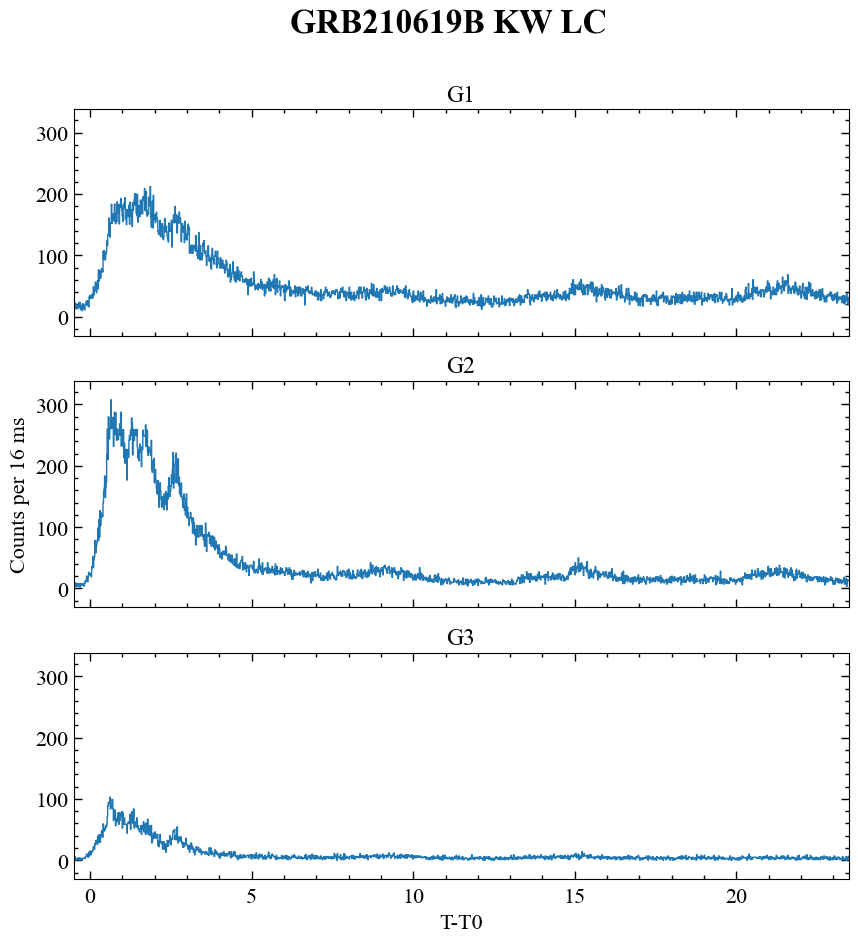

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True, sharex=True)

# Plot the data for 'G1' in the first subplot
axs[0].step(x=kw_bin_lo[:1500],y=G1[:1500],where='pre')
axs[0].set_title('G1')

# Plot the data for 'G2' in the second subplot
axs[1].step(x=kw_bin_lo[:1500],y=G2[:1500],where='pre')
axs[1].set_title('G2')
axs[1].set_ylabel('Counts per 16 ms')

# Plot the data for 'G3' in the third subplot
axs[2].step(x=kw_bin_lo[:1500],y=G3[:1500],where='pre')
axs[2].set_title('G3')

plt.xlabel('T-T0')
plt.suptitle('GRB210619B KW LC', fontsize=24, fontweight='bold')
plt.show()


In [4]:
kw_dt = np.round(np.diff(kw_bin_lo[:1500]),3)
np.all(kw_dt==0.016)

True

# ASIM

In [ ]:
df = harvest_data(fn='2021_6_19_23_59_24.mat',T0='2021-06-19T23:59:24.915')
df.sort_values(by='tus',inplace=True,ignore_index=True)
tlagg = 0 #s
tus = df['tus'].to_numpy() + tlagg
df['tus'] = tus
T0 = datetime.fromisoformat('2021-06-19T23:59:24.915') + timedelta(seconds=tlagg)
print('tlagg applied!')

In [ ]:
i,j = find_nearest(tus,-0.5),find_nearest(tus,5)
asim_tus = tus[i:j]
plot_lightcurve(tus=asim_tus)

In [ ]:
plot_HED(tus_arr=(asim_tus)*1e6,binsize=50,T0=T0)

In [ ]:
asim_tus_bkg = tus[:i]

asim_hist_bkg = np.histogram(asim_tus_bkg,bins=np.arange(min(asim_tus_bkg),max(asim_tus_bkg)+binsize,binsize))
asim_bkg_counts,asim_bkg_edges = asim_hist_bkg[0],asim_hist_bkg[1]

plt.step(x=asim_bkg_edges[:-1],y=asim_bkg_counts)
plt.title('ASIM GRB210619B background')
plt.show()
asim_bkg = np.mean(asim_bkg_counts)
print(f'{round(asim_bkg,4)} cts/{binsize} s')
print(f'background countrate {round(len(asim_tus_bkg)/(asim_tus_bkg[-1]-asim_tus_bkg[0]),4)}')

### Subtracting bkg from ASIM burst LC

In [ ]:
asim_counts,asim_edges = np.histogram(asim_tus,bins=bins)
asim_counts_no_bkg = np.clip(asim_counts-asim_bkg,0,None)
plt.step(x=asim_edges[:-1],y=asim_counts_no_bkg/max(asim_counts_no_bkg))
plt.show()

# FERMI
    - first using ToF to shift FERMI LC into KW ref. frame. Superimposing LCs to verify.
    - Applied CC func., but 16 ms resolution was too low; NEED 2 ms!

In [5]:
GRB_id = "GRB210619B"
bn='bn210619999' # GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 319.7161, 33.8495  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


glg_trigdat_all_bn210619999_v01.fit
645839970.604186
['n2', 'n3', 'n4', 'n7', 'n8']
n8 25.951
n4 50.99
n7 68.489
nb 71.935
b1 75.565
n3 83.874
n6 90.944
b0 104.435
n5 107.661
n9 124.022
n0 126.455
na 128.196
n1 144.321
n2 155.105


In [6]:
print(f'lat {np.round(trigdat.get_latitude(645839970.604186),4)}')
print(f'lon: {np.round(trigdat.get_longitude(645839970.604186),4)}')
print(f'alt: {np.round(trigdat.get_altitude(645839970.604186)/1e3,4)} km')

lat 24.3191
lon: 277.5315
alt: 534.4315 km


In [7]:
unit = all_dets[idx_sort_angsep][4] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v02.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

b1


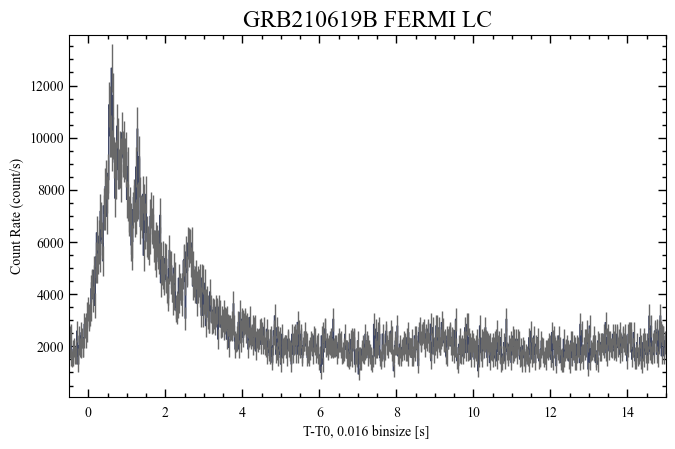

In [109]:
# open a TTE file
tte = TTE.open(fn_tte)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,1e5) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.5,15)
lcplot.ax.set_title(f'GRB210619B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

In [11]:
# applying the ToF
KW_T0 = datetime.fromisoformat('2021-06-19T23:59:28.157')
tof_kw_asim = -2.6183 # reached KW first
tof_asim_fermi = 0.0227 #reaced ISS first
fermi_shift_T0 = KW_T0 + timedelta(seconds=tof_kw_asim+tof_asim_fermi)
print(fermi_shift_T0)
fermi_T0 = datetime.fromisoformat('2021-06-19 23:59:25.604') # calculated from MET = 645839970.604186
print(fermi_T0)
print(f'fermi_tlagg estimation: {(fermi_T0-fermi_shift_T0).total_seconds()} s')

2021-06-19 23:59:25.561400
2021-06-19 23:59:25.604000
fermi_tlagg estimation: 0.0426 s


In [12]:
# KW formatting
i_stp_kw = find_nearest(kw_bin_hi,5+binsize) #closest up to 5 s
kw_lo = kw_bin_lo[:i_stp_kw]
kw_hi = kw_bin_hi[:i_stp_kw]
print('last bin edges for kw:',kw_lo[-1],kw_hi[-1])

bins = np.arange(kw_lo[0],kw_lo[-1]+binsize,binsize)

last bin edges for kw: 4.976 4.992


In [13]:
# fermi bkg estimation
tus_fermi = tte.data.time

i_bkg,j_bkg = find_nearest(tus_fermi,-80),find_nearest(tus_fermi,-20)
tus_fermi_bkg = tus_fermi[i_bkg:j_bkg]

fermi_bkg_c,fermi_bkg_e = np.histogram(tus_fermi_bkg,bins=np.arange(min(tus_fermi_bkg),max(tus_fermi_bkg)+binsize,binsize))
fermi_mean_bkg = np.round(np.mean(fermi_bkg_c),4)
print(fermi_mean_bkg)

38.0011


In [110]:

#fermi
tus_fermi = tte.data.time #+ 0.024035036496349676 #0.0426
ix,jx = find_nearest(tus_fermi,kw_lo[0]), find_nearest(tus_fermi,kw_hi[-1])
tus_fermi = tus_fermi[ix:jx]
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)
fermi_counts = fermi_counts - fermi_mean_bkg
fermi_edges = np.round(fermi_edges,3)

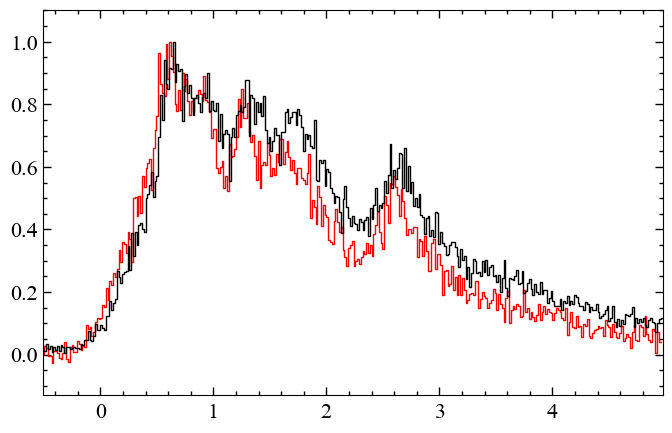

In [111]:
#bin edges are aligned!

plt.step(x=fermi_edges[:-1],y=fermi_counts/max(fermi_counts),c='r',where='pre')
kw_c = G2[:i_stp_kw]+G3[:i_stp_kw]
plt.step(x=kw_lo,y=kw_c/max(kw_c),c='black',where='pre')
plt.show()

In [ ]:
# FERMI LC shifted by 0.0426 s --> seems to have a good correlation
plt.step(x=fermi_edges[:-1],y=fermi_counts,c='r')
plt.step(x=kw_lo,y=G2[:i_stp_kw]+G3[:i_stp_kw],c='black')
plt.show()

# cross correlation

In [114]:
kw_lc = LC(time=kw_lo,counts=G2[:i_stp_kw]+G3[:i_stp_kw],dt=binsize)
fermi_lc = LC(time=fermi_edges[:-1],counts=fermi_counts,dt=binsize)
#fermi_lc = LC.make_lightcurve(tus_fermi, dt=binsize)

cc = CC(fermi_lc,kw_lc,mode='same',norm='variance') #remember: the output value should be applied to the first input-LC
tlagg=cc.time_shift
print("Total lagg (s): ", tlagg)
cc.plot()



#bin edges are NOT aligned!
print(round(fermi_lc.bin_lo[0],3), round(fermi_lc.bin_lo[-1],3))
print(round(kw_lc.bin_lo[0],3), round(kw_lc.bin_lo[-1],3))

TypeError: __init__() got an unexpected keyword argument 'norm'

In [122]:
import stingray
print(stingray.__version__)

0.3


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'conda-forge'
Note: you may need to restart the kernel to use updated packages.


In [69]:
len(fermi_counts),len(fermi_edges[:-1])

(343, 343)

In [ ]:
#fermi
tus_fermi += tlagg
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)
fermi_counts = fermi_counts - fermi_mean_bkg
fermi_edges = np.round(fermi_edges,3)


plt.step(x=fermi_edges[:-1],y=fermi_counts/max(fermi_counts),c='r',where='pre')
plt.step(x=kw_lo,y=kw_c/max(kw_c),c='black',where='pre')
plt.show()

In [ ]:
plt.step(x=fermi_edges[:-1],y=fermi_counts/max(fermi_counts),c='r',where='pre')

kw_c = G2[:i_stp_kw]+G3[:i_stp_kw]
plt.step(x=kw_lo,y=kw_c/max(kw_c),c='black',where='pre')
plt.show()

In [124]:
%connect_info

{
  "shell_port": 60318,
  "iopub_port": 60319,
  "stdin_port": 60320,
  "control_port": 60322,
  "hb_port": 60321,
  "ip": "127.0.0.1",
  "key": "54f24700-3414f9882749b0115c18e22f",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-5ec3947b-a27a-44a8-99d4-27b76a4cd73e.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# super plots

In [ ]:
import roman
plt.figure(figsize=(14, 8))
plt.step(x=fermi_edges[:-1],y=fermi_counts/max(fermi_counts),color='black',label='FERMI, inc. bkg',where='post')
plt.step(x=asim_edges[:-1],y=asim_counts_no_bkg/max(asim_counts_no_bkg),color='red',label='ASIM, ex. bkg',where='post')
plt.title('GRB210619B')
plt.xlabel(f'T-T0, {binsize} s binsize')
plt.ylabel(f'Normalized counts / {binsize} s')

P = [[1.5, 2.5],
     [2.5, 3.5], 
     [3.5, 4.5], 
     [4.5, 5.5],
     [5.5, 6.5],
     [6.5, 7.5],
     [7.5, 7.9]]

colors = ['Orange','Blue','Green','Orange', 'Purple', 'Red','brown']

for i, p in enumerate(P):
    plt.vlines(x=p, ymin=0,ymax=1.1, color=colors[i], alpha=0.9, linestyle= "--", label=f' Interval {roman.toRoman(i+1)} ')
    plt.text( ((p[1]+p[0]) / 2) - 0.1, 1.05, roman.toRoman(i+1), fontsize=16, c= "blue")


plt.ylim(bottom=0,top=1.2)
#plt.grid()
#plt.legend()
#plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/GRB211211A_correlated_intervals.png')
plt.show()

### cc results

# Extraction of FITS files

## ASIM extraction

In [ ]:
#harvesting new dataframe and shifting by tlagg
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323')
df.sort_values(by='tus',inplace=True,ignore_index=True)

tlagg=1.79 #s

T0 = datetime.fromisoformat('2021-12-11T13:10:01.323')+timedelta(seconds=tlagg)
tus = df['tus'].to_numpy() + tlagg
df['tus'] = tus
print(T0)

dau/det starting from index 1
tus array given in seconds
safety time:  6.311 % removed
sorted by tus (s)
2021-12-11 13:10:03.113000


In [ ]:
i_start,i_end = find_nearest(tus,5.9),find_nearest(tus,6.5)
tus_burst = tus[i_start:i_end]
plot_HED(tus_arr=tus_burst*1e6,binsize=2,T0=T0)

In [126]:
df_burst = df.truncate(before=i_start,after=i_end)
#plot_HED(tus_arr=df_burst['tus'].to_numpy()*1e6,binsize=2,T0=T0) #same interval

In [127]:
df_keV = keV_hist(df=df_burst,time_interval='max',keV_interval='max',convert_seconds=False)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  13342
n triggers are within bounds  13342
keV bins are set for HED
Energies binned!


In [136]:
bin_lo = df_keV['bins_keV'].to_numpy()[:-1]
bin_hi = df_keV['bins_keV'].to_numpy()[1:]
counts = df_keV['counts'].to_numpy()[1:]
err = df_keV['poisson_error_counts'].to_numpy()[1:]
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [134]:
print('Exposure: ',np.round(tus_burst[-1]-tus_burst[0],3))
print(T0)

Exposure:  0.6
2021-12-11 13:10:03.113000


# FITS 

In [102]:
#harvesting data
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323') 
df.sort_values(by='tus',inplace=True,ignore_index=True)

tlagg=1.79 #s

T0 = datetime.fromisoformat('2021-12-11T13:10:01.323') + timedelta(seconds=tlagg)
tus = df['tus'].to_numpy() + tlagg
df['tus'] = tus
print(f'T0: {T0}')

dau/det starting from index 1
tus array given in seconds
safety time:  6.311 % removed
sorted by tus (s)
T0: 2021-12-11 13:10:03.113000


## Single file

### PHA

In [141]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [5.90,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [6.50,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.6,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB211211A.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB211211A.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB211211A.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [142]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK
    T0+80s background accumulation

In [ ]:
tus_bkg = df['tus'].to_numpy()
i_bkg_start = find_nearest(tus_bkg,80)
plot_lightcurve(tus=tus_bkg[i_bkg_start:])
df_bkg = df.truncate(before=i_bkg_start)
df_bkg.head()

In [ ]:
df_kev_bkg = keV_hist(df_bkg,time_interval='max',keV_interval='max',convert_seconds=False)

In [108]:
print('Exposure bkg',np.round(tus_bkg[i_bkg_start:][-1]-tus_bkg[i_bkg_start:][0],3))
print('start',round(tus_bkg[i_bkg_start:][0],3))
print('end',round(tus_bkg[i_bkg_start:][-1],3))

Exposure bkg 2.01
start 81.468
end 83.478


In [109]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [81.468,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [83.478,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [2.01,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [110]:
bak_counts = df_kev_bkg['counts'].to_numpy()[1:]
bak_err = df_kev_bkg['poisson_error_counts'].to_numpy()[1:]

generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP
    -generate new respone for each pha file, since exposure is varying (?)

In [155]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.113','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [5.90,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [6.50,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.60,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A.rsp','RSP filename'] #<str>  ('example.pha')
}

In [ ]:
theta,phi = 112.775,-177.757
drm_path = '/Users/andreas/phys/master/GRB/xspec/ASIM/GRB211211A/'#'/Home/siv30/wad005/master/HED_DRM/data'
drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

In [157]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)

## FERMI extraction

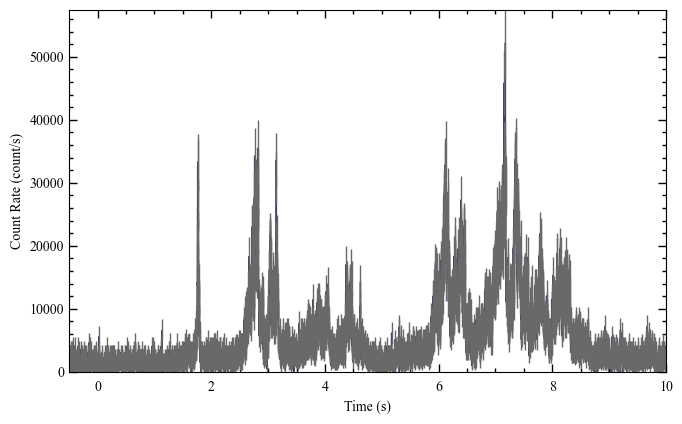

In [21]:
tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)
binsize = 0.002 # 4ms binning
#phaii = tte.to_phaii(bin_by_time, binsize, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, binsize) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350, 1e5) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.5,10)

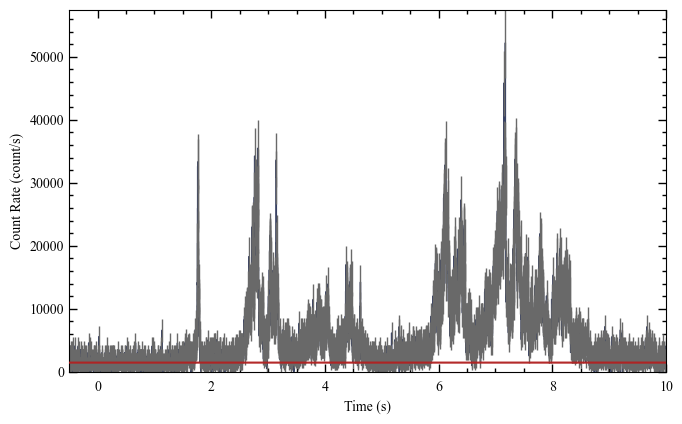

In [22]:
# Fit background
bkgd_times = [(-100.0, -50.0), (150,200)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-0.5,10)
lcplot.xlim = view_range

Normalised residuals: mean= 0.00141  std= 1.03
NormaltestResult(statistic=3122.408506924648, pvalue=0.0)


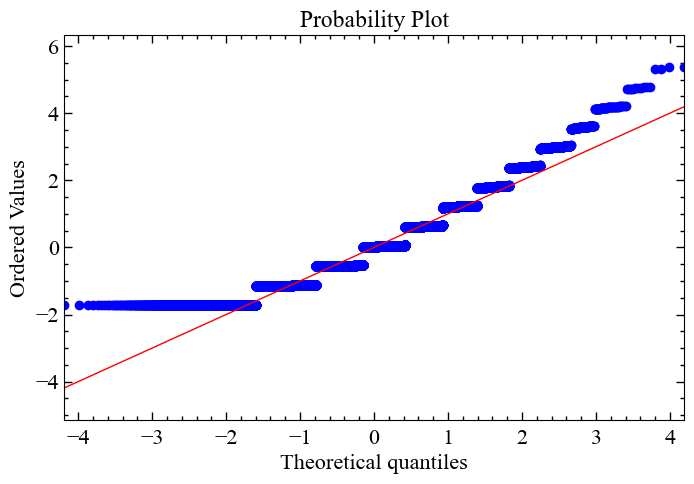

In [23]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]

if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

In [ ]:
# Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.
# our lightcurve source selection

#intervals
P = [[1.5, 2.5],
     [2.5, 3.5], 
     [5.5, 6.5]]

for i, p in enumerate(P):
    src_time = (p[0],p[1])
    src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

    lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
    lcplot.add_selection(src_lc)
    lcplot.xlim = view_range
    plt.show()

In [ ]:
for i, p in enumerate(P):
    time_selection = (p[0],p[1])
    src_time=(-0.5,10)
    #spec_data = tte.to_spectrum(time_range=(-0.5,10))
    spec_data = phaii.to_spectrum(time_range=src_time)

    # the background model integrated over the source selection time
    spec_bkgd = bkgd.integrate_time(*src_time)
    
    # and the energy range selection that was made
    spec_selection = phaii.to_spectrum(time_range=time_selection, energy_range=erange)
    
    specplot = Spectrum(data=spec_data, background=spec_bkgd)
    specplot.add_selection(spec_selection)
    plt.show()

In [25]:
GRB_id = 'FERMI_GRB211211A'
pha = tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")


fparkey FERMI_GRB211211A_n2.rsp FERMI_GRB211211A_n2.pha+2 RESPFILE


# FERMI fits interval extraction

In [ ]:
tte = TTE.open(fn_tte)
binsize = 0.002
phaii = tte.to_phaii(bin_by_time, binsize)
erange = (350, 1e5)
lc_data = phaii.to_lightcurve(time_range=(-0.5,10),energy_range=erange)
lc_bkgd = bkgd.integrate_energy(*erange)

#intervals
P = [[1.5, 2.5],
     [2.5, 3.5], 
     [5.5, 6.5]]

print(f"erange {erange}")

for i, p in enumerate(P):
    GRB_id = f'FERMI_GRB211211A_{i+1}'
    
    src_time = (p[0],p[1])
    src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

    lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
    lcplot.add_selection(src_lc)
        
    bak = bkgd.to_bak(time_range=src_time) #background spectrum
    pha = phaii.to_pha(time_ranges=src_time,energy_range=erange)
    
    fn_spectral = GRB_id + "_" + unit
    bak.write('./', filename=fn_spectral+'.bak')
    pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

    # Read RSP function
    rsp = RSP.open(fn_rsp)
    # and interpolate response files to get DRMs at center of the source window
    rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

    # Write response file
    rsp_interp.write('./', filename=fn_spectral+'.rsp')

    # It's advisable to set the RESPFILE keyword properly in the PHA file:
    print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")
    plt.show()